### Blockchain project #2
This file will be our main file for this project. 
Lets explain our process here
First start of with creating block and blockchain class.
We need to force a fork such that the smaller fork can be the uncle
implement reward.


### Tasks: 
- model a blockchain that uses uncle and uncle rewards
- model a rewarding mechanism to reward uncle block creators
- model selfish mining (only one attacker) in this blockchain

### Answer the following questions: 
- How do uncles improve the fairness of the blockchain? For this, you should compare the outcome of miners with and without uncles

Miners with lower miningpower, that in a normal situation would be unable to gain a block. They will now with the uncle reward get rewards event thought their block was not used. This makes it so that the miningpower used for the uncle block will not all be wasted. 

*** 

- What is the impact of the uncles on selfish mining? Is selfish mining more profitable with uncles?

It makes it more profitable for selfish miners, because the risk in selfish mining is that sets you at risk of losing everything. While with uncles the selfish miners will receive almost full reward, thus selfish mining is much less risky. Yes, much more.

***

- What does it mean in this model for the selfish mining attack to be profitable?

If a selfish miner mines a block, and is not chosen to be in the longest chain. Normally the block is discarded without any reward. However with uncles, the selfish mined block will receive reward for using resources to mine a block. Therefore the selfish miner, will receive reward either if he succeeds in creating an accepted block or not. Thus selfish mining will always be "worth the power". 

# Fairness
In order to gain some sense of basis of comparison we developed our own fairness algorithm, and altough a bit basic we hope this will grant us a bit of perspective when comparing different modules. 

We choose to define Fairness for a spesific miner as the relationship between Reward over Contribution.
 $$
   Fairness = \frac{Reward}{Contribution} 
$$  

Where Reward is the fraction of the miners reward over total rewards.
 $$
   Reward = \frac{My Reward}{Total Reward} 
$$  
And Contribution is the fraction over My Hashpower over total Hashpower in the system.
$$
   Contribution = \frac{My Hashpower}{Total Hashpower}
$$  


This is used as the fairness for a spesific miner.

This means that a Fairness value of 1 says that it is perfectly fair and you got the percentage you put in. A Fairness value > 1 indicates that you got more than you should have, and a Fairness value < 1 indicates that you got less. 

 In order to gain the fairness of the entire system we will use the median and the standard deviation, in addition to the extremes. The median is the middle number in the sorted fairness list and is more descriptive of Fairness in the data set set than the average. However the average also tells us about how much mining power is wasted. As the average should be 1 if all mining power is used. But forks will decrease this number as you don't get the full reward sum for your effort. We often use the Median to prevent ouliers skew the system. But as the outliers probably are Big miners, selfish miners and uncle miners we want these values as well. The standard deviation should also give us a good view on the fairness as we get a good picture on how the fairness is dispersed. 

 We may also plot this to try to illustrate the fairness.


Start off with declearing block, miner and blockchain:

In [13]:
#import statements
from IPython.display import HTML, display
import hashlib as hasher
import random
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import statistics

BASEREWARD = 10 #Base reward
UNCLEREWARD = 5 #Base uncle reward
NEPHEWREWARD = 2 #Base nephew reward
BLOCKCHAINSIZE = 10000 #Base blockchainsize 
BASEDIFFICULTY = 5 # base difficulty
def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def hash(input):
    hash_obj = hasher.sha256()
    inputbytes = input.decode()
    hash_obj.update(inputbytes)
    return hash_obj.hexdigest()

def numberOfInitZeros(hashStr):
    count = 0
    for i in range(0, len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

class Block: 
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0, "0")
            self.height = 0
            
        else: 
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []
    
    def hash_block(self):
        return hashbits(self.data+self.creator.name+self.previous_hash+str(self.nonce))

    def print(self):
        print(self.data+" "+self.creator.name+" "+str(self.height))

class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.forked = []
        self.mainchain = []
        self.mainchainPrint = []
        self.uncles = []
        self.uncleBlocks = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0
    
    def longestChain(self):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        
        r = random.choices(maxes, k=1)
        return r[0]
    
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size += 1

    def print(self):
        for block in self.chain:
            block.print()
            print("______")

    def hasFork(self): #This checks if the chain has a fork        
        for block1 in self.chain:
            for block2 in self.chain:
                if block1 != block2 and block1.height == block2.height:
                    return True
        return False

    def checkMiner(self, miner):
        last = self.longestChain()
        count = 0
        while last != None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count

    def createMainChain(self):
        lb = self.longestChain()
        while lb.previous != None or lb.height ==0:
            self.mainchain.append(lb)
            self.mainchainPrint.append(lb.creator.name)
            if lb.height == 0:
                break
            lb = lb.previous
 
    def getUncles(self): #Append blocks that are not in mainchain to uncle list
        for block in self.chain:
            if block not in self.mainchain:
                self.uncles.append(block.creator.name)
    def getUnclesBlock(self):
        for block in self.chain:
            if block not in self.mainchain:
                self.uncleBlocks.append(block)
   
def bitToHex(bitBlock):
    return hex(int(bitBlock,2))

class Miner:
    def __init__(self, miningPower, name, blockchain=None):
        self.reward = 0 # added reward attribute
        self.miningPower = miningPower
        self.nonce = random.randint(0,100000)
        self.name = name
        self.MinedLastBlock = False
        self.blockchain = blockchain
        self.fairness = None
        self.coins = []
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain()

    
    def UpdateLast(self):
        latest = self.blockchain.longestChain()             
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
         
    
    def PoWSolver(self):
        for i in range(0, self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                bc.add(newBlock)
                self.lastBlock = newBlock
                self.MinedLastBlock = True
            self.nonce += 1




In [14]:
class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        #self.nonce = random.randint(0,100000)
        self.reward = 0
        self.fairness = None
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height: 
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height -1 and len(self.privateBlocks) > 1:
            for block in self.privateBlocks: 
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        for i in range (0, self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else: 
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

def attackerHasControl(blockchain, attacker):
    if blockchain.longestChain().creator == attacker: 
        return True
    return False

In [15]:
class UncleMiner:
    def __init__(self, miningPower, name, blockchain=None):
        self.reward = 0 # added reward attribute
        self.miningPower = miningPower
        self.fairness = None
        self.nonce = random.randint(0,100000)
        self.usedNonce= []
        self.name = name
        self.coins = []
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain()

    
    def UpdateLast(self):
        latest = self.blockchain.longestChain()  
        if latest.previous != None:
            blockToMine = latest.previous
        self.lastBlock = blockToMine
         
    
    def PoWSolver(self):
        for i in range(0, self.miningPower):
            nonce = self.nonce
            while nonce in self.usedNonce:
                nonce = self.nonce
            self.usedNonce.append(nonce)
            
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                bc.add(newBlock)
                self.lastBlock = newBlock
                self.MinedLastBlock = True
                self.usedNonce = []
                self.UpdateLast()
            self.nonce += 1


In [16]:
#Drawing the blockchain
def maxHeight(parent):
  if len(parent.children) == 0:
    return parent.height 
  max = 0
  for child in parent.children:
    m = maxHeight(child)
    if m> max:
      max = m
  return max
  

def drawBlockchain(parent, level, html, parentLevel, childN = 0, total = 0):
  color = "#AEF751"
  if parentLevel!=-1:
    color = "#7EDBF6"
  elif type(parent.creator) is SelfishMiner:
      color = "#F59AEE"
  parent.children.sort(key=lambda x: (maxHeight(x)), reverse=True)
  xx = childN
  level += childN
  html += '<g>'
  html += '<rect x="'+str(30+ 100*parent.height)+'" y="'+str(30+ 100*level)+'" width="60" height="60" stroke="black" stroke-width="1" fill="'+color+'" />'
  html += '<text x="'+str((60+ 100*parent.height))+'" y="'+str((60+ 100*level))+'" dominant-baseline="middle" text-anchor="middle" font-family="Verdana" font-size="10" font-weight="bold" fill="black">'+str(parent.creator.name)+'</text>'
  if parentLevel != -1:
    if (parent.previous.children.index(parent)) == 0:
      html += '<line stroke-width="1px" stroke="#000000"  x1='+str(30+ 100*parent.height)+' y1="'+str(60+ 100*level)+'" x2="'+str(95+ 100*parent.previous.height)+'" y2="'+str(60+ 100*parentLevel)+'" style="marker-end: url(#markerArrow)"/>'
    else:
      html += '<line stroke-width="1px" stroke="#000000"  x1='+str(30+ 100*parent.height)+' y1="'+str(60+ 100*level)+'" x2="'+str(65+ 100*parent.previous.height)+'" y2="'+str(95+ 100*parentLevel)+'" style="marker-end: url(#markerArrow)"/>'
  html += '</g>'
  l = level
  childN = 0
  for child in parent.children:
    html,n, t = drawBlockchain(child, l, html, level, childN, total)
    if n > 0:
      childN += n
    if t > 0:
      total += t
    l = l+1
  return html, childN+ len(parent.children)-1, total+ len(parent.children)-1


def show(bc):
  htmll = ""
  html = ""
  htmll, n, t = drawBlockchain(bc.chain[0], 0, html, -1)
  html = '<svg height="'+str(115*(n+1))+'" width="'+str(115*maxHeight(bc.chain[0]))+'">'
  html += '<defs><marker id="markerArrow" markerWidth="10" markerHeight="10" refX="2" refY="6" orient="auto"><path d="M2,2 L2,11 L10,6 L2,2" style="fill: #000000;" /> </marker> </defs>'
  html += htmll
  html += '</svg>'
  display(HTML(html))

In [17]:
# a simple function calculating base rewards not worrying about uncle
def calculateBaseRewards(miners, mainchain):
  for minerName in mainchain:
    for miner in miners: 
      if miner.name == minerName:
        miner.reward += BASEREWARD
      miner.coins.append(miner.reward)

# calculating unclerewards
def calculateUncleRewards(miners, uncleChain, mainchain):
  for block in uncleChain:  
    minerName = block.creator.name 
    height = block.height 
    for mainBlock in mainchain:
      if mainBlock.height == height:
        nephewName = mainBlock.creator.name

    for miner in miners: 
      if miner.name == minerName:
        for i in range(height,len(miner.coins)):
          miner.coins[i] += UNCLEREWARD
        miner.reward += UNCLEREWARD
        
      if miner.name == nephewName:
        miner.reward += NEPHEWREWARD
        for i in range(height,len(miner.coins)):
          miner.coins[i] += NEPHEWREWARD

def showRewards(miners):
  for m in miners:
    print(m.name," earned: ", m.reward," coins")

def visualizeRewards(miners, withOrWithout):
  def getReward(elem):
    return elem.reward
  names = []
  coins = []
  nameCoinDict = {}
  miners.sort(key=getReward)
  for m in miners:
    names.append(m.name)
    coins.append(m.reward)
    nameCoinDict[m.name] = m.reward
  plotdata = pd.DataFrame({"coins": coins, "name": names})
  average=  sum(coins)/len(coins)
  
  s = "Coins rewarded "+ withOrWithout+ " uncle reward : "+ str(sum(coins))+" average: " + str(average)  
  #print(plotdata)
  fig = px.bar(x= names, y= coins, title=s, color=coins, labels={"x": "Miners", "y":"Coins rewarded"})
  fig.add_trace(
    go.Scatter(
        x=names,
        y=[average]*len(miners),
        mode="lines",
        line=go.scatter.Line(color="gray"),
        showlegend=False)
)
  fig.show()
    
#Calculate fairness for a spesific miner
def calculateFairness(MyReward, MyHash, TotalReward, TotalHash):
    return (MyReward/TotalReward)/(MyHash/TotalHash)

#Visualize fairness of the entire system
def VisualizeFairnessOfSystem(miners, withorwithout):
    def getFairness(elem):
      return elem.fairness
    fairnessList = []
    totalReward = 0
    totalHash = 0
    names = []
    
    for miner in miners:
      totalReward+= miner.reward
      totalHash += miner.miningPower
      names.append(miner.name)
    for miner in miners:
      miner.fairness = calculateFairness(miner.reward,miner.miningPower,totalReward, totalHash)
    miners.sort(key=getFairness)
    for miner in miners:
      fairnessList.append(miner.fairness)
    std =np.std(fairnessList)
    median = np.median(fairnessList)
    minimum = np.min(fairnessList)
    s = "Reward to effort ratio: " + withorwithout + " unclereward"
    fig = px.bar(x= names, y= fairnessList, title=s, color=fairnessList, labels={"x": "Miners", "y":"Ratio"})
    fig.show()
    
    print("Standard deviation of fairness: ", std)
    print("Median fairness of system: ", median)
    print("Minimum fairness of system: ", minimum)
    print("Maximum fairness of system: ", np.max(fairnessList))
    print("average: ", np.average(fairnessList))


def analyzeBlockchain(miners, blockchain):
  blockchain.createMainChain()
  blockchain.getUncles()
  blockchain.getUnclesBlock()
  calculateBaseRewards(miners,bc.mainchainPrint)
  print("Rewards given to miners without uncle as well as fairness of the system")
  visualizeRewards(miners, "without")
  VisualizeFairnessOfSystem(miners, "without")
  print("Plotting all miners against eachother without unclereward")
  visualizeLines(miners)
  print("visualizes average miners vs deviant miners without unclereward")
  plotLinesForMiners(miners)
  calculateUncleRewards(miners, bc.uncleBlocks, bc.mainchain)
  print("Plotting all miners against eachother with unclereward")
  visualizeLines(miners)
  print("visualizes average miners vs deviant miners with unclereward")
  plotLinesForMiners(miners)
  visualizeRewards(miners, "with")
  VisualizeFairnessOfSystem(miners, "with")
  
#Plots all miners against eachother
def visualizeLines(miners):
  allCoins = []
  minername = []
  for m in miners: 
    allCoins.append(m.coins)
    minername.append(m.name)
  i = 0
  for wallet in allCoins: 
    currentName = minername[i]
    i += 1

    timefilteredForce = plt.plot(wallet, label=currentName)
    timefilteredForce = plt.xlabel("Nr of blocks mined")
    timefilteredForce = plt.ylabel("Money")
    timefilteredForce = plt.title("Evolution of coins")
    
  plt.legend()
  plt.show()
#visualizes average miners and deviant miners
def plotLinesForMiners(miners):
  averageMiner =[]
  otherminers = []
  bigminer = []
  selfishMiner = []
  uncleMiner = []
  legends=["averageMiner"]
  totalNormalMiners = 0
  for miner in miners:
    if miner.name != "big" or miner.name != "selfish" or miner.name != "uncleMiner":
      totalNormalMiners +=1
    if miner.name == "big":
      bigminer = miner.coins
      legends.append("big")
      otherminers.append(bigminer)
    if miner.name == "selfish":
      selfishMiner = miner.coins
      legends.append("selfish")
      otherminers.append(selfishMiner)
    if miner.name == "uncleMiner":
      uncleMiner = miner.coins 
      otherminers.append(uncleMiner)
      legends.append("uncleMiner")

  for i in range(len(miners[0].coins)):
    averageMiner.append(0)
    for miner in miners:
      if miner.name != "big" or miner.name != "selfish" or miner.name != "uncleMiner":
        averageMiner[i] += miner.coins[i]
    averageMiner[i] = averageMiner[i]/totalNormalMiners
  
  if len(selfishMiner) > 0:
    minerName = "selfish"
    timefilteredForce = plt.plot(selfishMiner, label="miner %s"%minerName)
  if len(uncleMiner) > 0:
    minerName = "uncleMiner"
    timefilteredForce = plt.plot(uncleMiner, label="miner %s"%minerName)
  if len(bigminer) > 0:
    minerName = "big"
    timefilteredForce = plt.plot(bigminer, label="miner %s"%minerName)
  
  
  timefilteredForce = plt.xlabel("Nr of blocks mined")
  timefilteredForce = plt.ylabel("Money")
  timefilteredForce = plt.title("Evolution of coins")

  minerName = "averageMiner"
  plt.plot(averageMiner, label="miner %s"%minerName)
  plt.legend()
  plt.show()
  

## Modelling blockchain with uncle reward

Rewards given to miners without uncle as well as fairness of the system


Standard deviation of fairness:  0.2571052564781359
Median fairness of system:  0.7780979827089338
Minimum fairness of system:  0.590778097982709
Maximum fairness of system:  1.765609990393852
average:  0.8085975024015369
Plotting all miners against eachother without unclereward


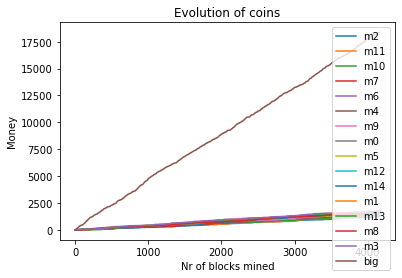

visualizes average miners vs deviant miners without unclereward


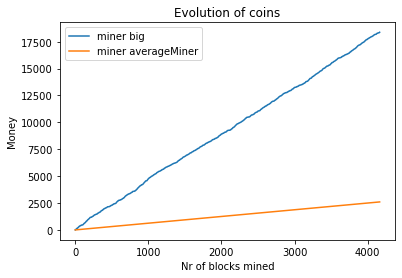

Plotting all miners against eachother with unclereward


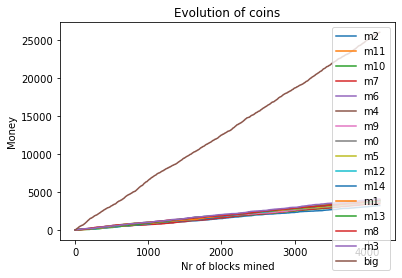

visualizes average miners vs deviant miners with unclereward


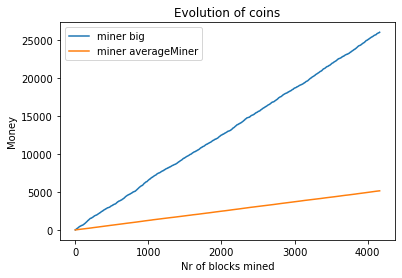

Standard deviation of fairness:  0.09856583257910882
Median fairness of system:  0.9274051806688566
Minimum fairness of system:  0.7796458138886532
Maximum fairness of system:  1.2640153213978351
average:  0.9339961696505412


In [18]:
#Declearing blockchain and printing properties
bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(15):
    m = Miner(5, "m"+str(i), bc)
    miners.append(m)

big = Miner(25, "big", bc)
while bc.size < BLOCKCHAINSIZE:
    big.PoWSolver()

    for m in miners:
        m.PoWSolver()

    big.UpdateLast()
    
    for m in miners:
        m.UpdateLast()
#appended to calculate rewards
miners.append(big)
analyzeBlockchain(miners,bc)


## Modelling blockchain with selfish miner and uncle rewards

alpha 0.07865168539325842
Rewards given to miners without uncle as well as fairness of the system


Standard deviation of fairness:  0.06027916276371826
Median fairness of system:  0.9943521594684386
Minimum fairness of system:  0.8484100616990983
Maximum fairness of system:  1.1169435215946844
average:  0.9993558885348159
Plotting all miners against eachother without unclereward


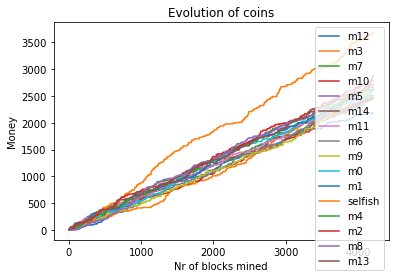

visualizes average miners vs deviant miners without unclereward


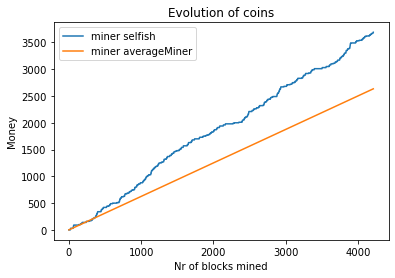

Plotting all miners against eachother with unclereward


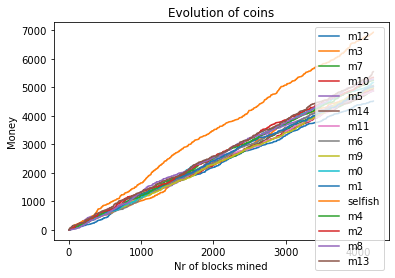

visualizes average miners vs deviant miners with unclereward


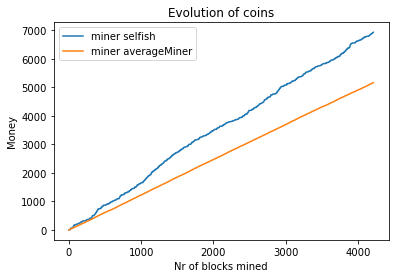

Standard deviation of fairness:  0.04657042538504866
Median fairness of system:  0.994231025178768
Minimum fairness of system:  0.8967029244152984
Maximum fairness of system:  1.1012837420900434
average:  1.0004266320740203


In [19]:

bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(15):
    m = Miner(5, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(7,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))

analyzeBlockchain(miners,bc)


## Another reward mechanism for uncles

# Implementing UncleMiner
The uncleminer will only work on blocks with the intention to get uncle rewards, it will not stop mining on a block until it gets its uncle reward. 


alpha 0.044642857142857144
Rewards given to miners without uncle as well as fairness of the system


Standard deviation of fairness:  0.3496912566028345
Median fairness of system:  0.754630593132154
Minimum fairness of system:  0.0
Maximum fairness of system:  2.002247658688866
average:  0.7848861140016187
Plotting all miners against eachother without unclereward


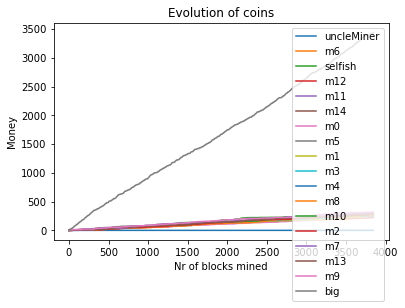

visualizes average miners vs deviant miners without unclereward


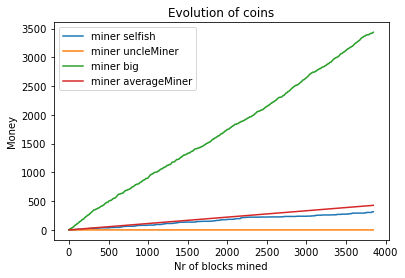

Plotting all miners against eachother with unclereward


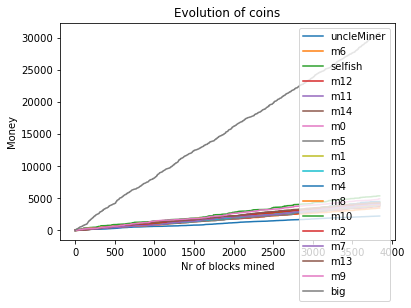

visualizes average miners vs deviant miners with unclereward


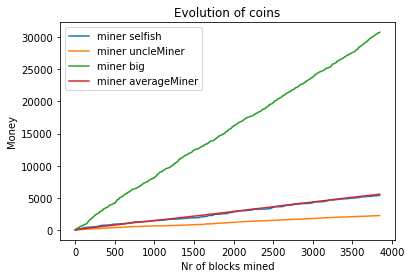

Standard deviation of fairness:  0.16209139841227746
Median fairness of system:  0.9038993232909849
Minimum fairness of system:  0.4993052987215498
Maximum fairness of system:  1.3777243785172375
average:  0.91919479068445


In [25]:

bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(15):
    m = Miner(5, "m"+str(i), bc)
    miners.append(m)

uncleMiner = UncleMiner(5,"uncleMiner", bc)
big = Miner(25,"big", bc)
selfish = SelfishMiner(7, "selfish", bc)
while bc.size < BLOCKCHAINSIZE: 
    uncleMiner.PoWSolver()
    selfish.PoWSolver()
    
    for m in miners: 
        m.PoWSolver()
    big.PoWSolver()
    big.UpdateLast()
    selfish.UpdateLast()
    uncleMiner.UpdateLast()
    for m in miners: 
        m.UpdateLast()


miners.append(uncleMiner)
miners.append(big)
miners.append(selfish)
total = 0
for m in miners: 
    total += m.miningPower
print("alpha {}".format(uncleMiner.miningPower/total))
analyzeBlockchain(miners,bc)



## Plotting wrong values
### Uncle: 10, Neph: 2, Block: 5

alpha 0.07865168539325842
Rewards given to miners without uncle as well as fairness of the system


Standard deviation of fairness:  0.06078398931144308
Median fairness of system:  1.0064625030142271
Minimum fairness of system:  0.8581625271280444
Maximum fairness of system:  1.1033518205931998
average:  0.9981647662682145
Plotting all miners against eachother without unclereward


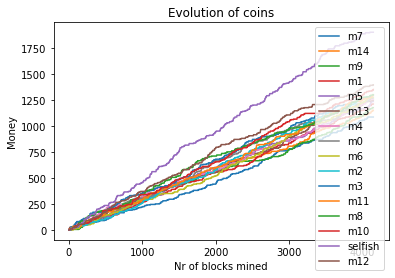

visualizes average miners vs deviant miners without unclereward


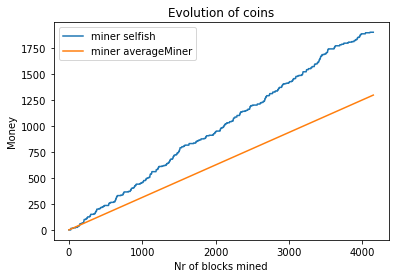

Plotting all miners against eachother with unclereward


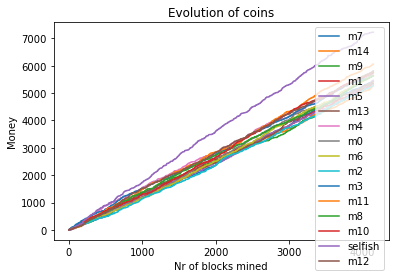

visualizes average miners vs deviant miners with unclereward


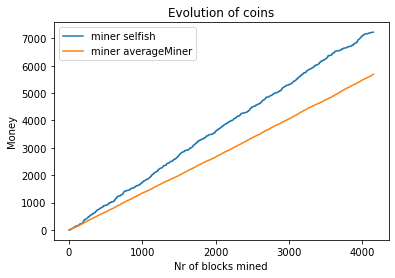

Standard deviation of fairness:  0.043977464765154836
Median fairness of system:  1.0004131550320305
Minimum fairness of system:  0.9301199750725611
Maximum fairness of system:  1.0925884822046656
average:  1.0017470006231861


In [21]:
BASEREWARD = 5
UNCLEREWARD = 10
NEPHEWREWARD = 2
bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(15):
    m = Miner(5, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(7,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
analyzeBlockchain(miners,bc)

### Uncle: 5, Neph: 10, Block: 2


In [22]:
BASEREWARD = 2
UNCLEREWARD = 5
NEPHEWREWARD = 10
bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(15):
    m = Miner(5, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(7,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
analyzeBlockchain(miners,bc)

KeyboardInterrupt: 

## Plotting reward over time

alpha 0.07865168539325842
Rewards given to miners without uncle as well as fairness of the system


Standard deviation of fairness:  0.09102330580028341
Median fairness of system:  0.9893499640201487
Minimum fairness of system:  0.8536339649796114
Maximum fairness of system:  1.1941883973546241
average:  0.9951452900661344
Plotting all miners against eachother without unclereward


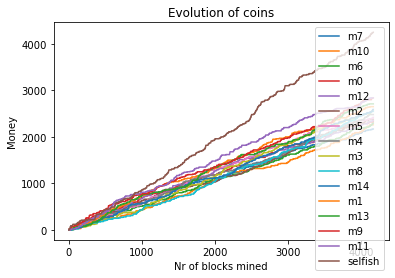

visualizes average miners vs deviant miners without unclereward


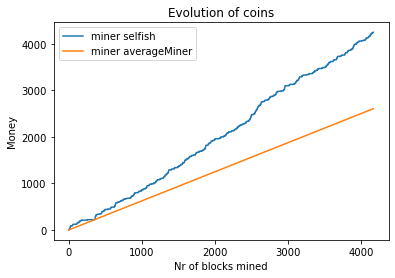

Plotting all miners against eachother with unclereward


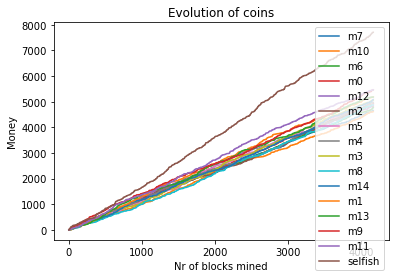

visualizes average miners vs deviant miners with unclereward


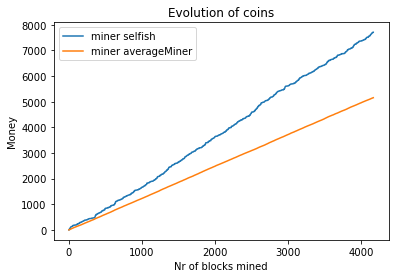

Standard deviation of fairness:  0.05347737888204554
Median fairness of system:  0.9833202031342796
Minimum fairness of system:  0.9177257687226539
Maximum fairness of system:  1.0946603664797272
average:  0.9976334908380067


In [ ]:
BASEREWARD = 10
UNCLEREWARD = 5
NEPHEWREWARD = 2

bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(15):
    m = Miner(5, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(7,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()

miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
analyzeBlockchain(miners,bc)

## Selfish vs Average Miner

alpha 0.07865168539325842
Rewards given to miners without uncle as well as fairness of the system


Standard deviation of fairness:  0.08965947332289487
Median fairness of system:  1.0220574162679426
Minimum fairness of system:  0.8631578947368421
Maximum fairness of system:  1.1691866028708133
average:  1.0015994531784007
Plotting all miners against eachother without unclereward


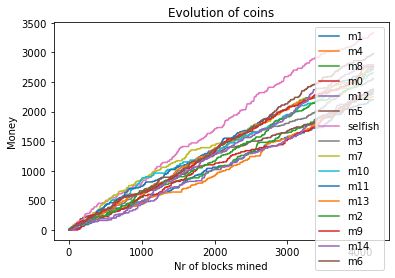

visualizes average miners vs deviant miners without unclereward


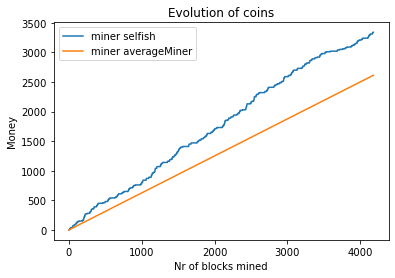

Plotting all miners against eachother with unclereward


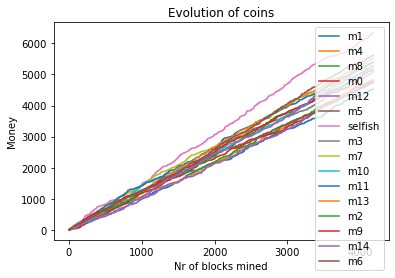

visualizes average miners vs deviant miners with unclereward


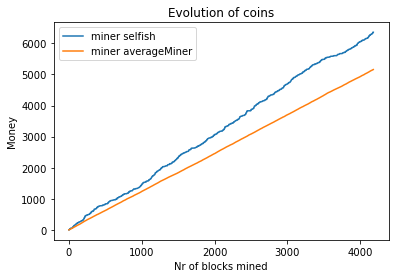

Standard deviation of fairness:  0.066844658539255
Median fairness of system:  1.0189895808093046
Minimum fairness of system:  0.8990792343106373
Maximum fairness of system:  1.116646474436637
average:  1.0024378656235937


In [ ]:
BASEREWARD = 10
UNCLEREWARD = 5
NEPHEWREWARD = 2

bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(15):
    m = Miner(5, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(7,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()

miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
analyzeBlockchain(miners,bc)

## BIG vs Uncle Vs Selfish Vs Random miner

Rewards given to miners without uncle as well as fairness of the system


Standard deviation of fairness:  0.31530907610407266
Median fairness of system:  0.6218250950570342
Minimum fairness of system:  0.493735288792323
Maximum fairness of system:  1.2173891001267427
average:  0.7776498279920333
Plotting all miners against eachother without unclereward


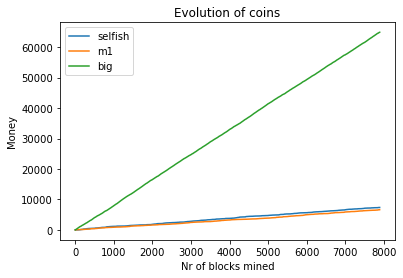

visualizes average miners vs deviant miners without unclereward


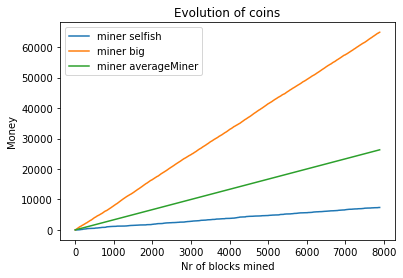

Plotting all miners against eachother with unclereward


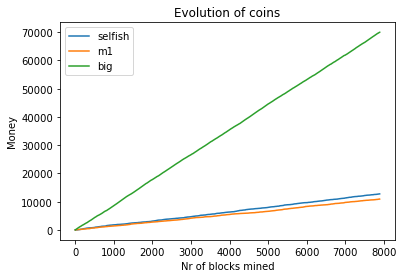

visualizes average miners vs deviant miners with unclereward


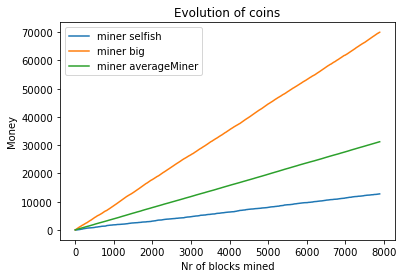

Standard deviation of fairness:  0.15924348170056601
Median fairness of system:  0.8629251628055941
Minimum fairness of system:  0.7200353825740822
Maximum fairness of system:  1.1058050603181382
average:  0.8962552018992715


In [ ]:
BASEREWARD = 10
UNCLEREWARD = 5
NEPHEWREWARD = 2

bc = Blockchain("0", BASEDIFFICULTY)
miners = []
m = Miner(5, "m1", bc)
selfish = SelfishMiner(7,"selfish", bc)
big = Miner(25, "big", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()
    m.PoWSolver()
    big.PoWSolver()
    
    selfish.UpdateLast()
    m.UpdateLast()
    big.UpdateLast()

miners.append(m)
miners.append(selfish)
miners.append(big)
analyzeBlockchain(miners,bc)